In [14]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = 1

True
11721506816
0


In [15]:
my_path = '../dataset/sharma_59_nih_dataset/Image_dataset/'
path_0 = my_path+'0_0/'
path_1 = my_path + '1_1/'
print(len(os.listdir(path_0)))
print(len(os.listdir(path_1)))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)
train_data,validate_data,test_data,extra = torch.utils.data.dataset.random_split(images,[8000,1500,2100,9733+9726-11600])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

9733
9726
{'0_0': 0, '1_1': 1}


torch.Size([64, 3, 224, 224])
tensor(1.)


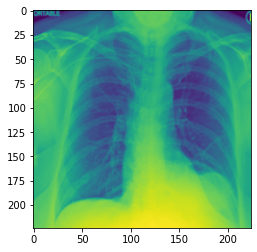

In [16]:
image,label = next(iter(train_loader))
print(image.shape)

print(torch.max(image))
plt.imshow(image[0][0])

In [17]:
class Model_class(object):

    def __init__(self,py_model,gpu_id=2):
        self.model = py_model
        self.fpr = {}
        self.tpr = {}
        self.auc_ = {}

        self.best_valid_acc = 0.65
        self.best_model = None
        self.best_optimizer = None

        self.val_acc = []
        self.train_acc = []
        self.val_loss = []
        self.train_loss = []

        self.gpu_id=gpu_id
        self.model = self.model.cuda(self.gpu_id)
        

    def train(self,train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular,regularization = 'None'):
        weight_decay = 0.0001
        self.n_epochs = n_epochs
        
        for epochs in range(n_epochs):
            batch_loss = []
            batch_acc = [] 
            val_batch_loss= []
            val_batch_acc = []
            for idx , (data,target) in enumerate(train_loader):


                """ mean normalization """
                data = self.Normalize_train(data)
                
                data = data.cuda(self.gpu_id)
                target = target.cuda(self.gpu_id)
                
                scores = self.model(data)
                
                reg_loss = 0
                if (regularization == 'l1'):
                    for params in self.model.parameters():
                        reg_loss += torch.sum(abs(params))

                if (regularization == 'l2'):
                    for params in self.model.parameters():
                        reg_loss += torch.norm(params)
                    
                loss = Losses_(scores,target) + weight_decay * reg_loss
                batch_loss.append(float(loss))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_accuracy = self.evaluate_batch(data,target)
                batch_acc.append(float(batch_accuracy))
                print(f'Train batches done: {idx+1}', end='\r')
                
            self.model.eval()

            for idx ,(data,target) in enumerate(validate_loader):

                data = self.Normalize(data)

                data = data.cuda(self.gpu_id)
                target = target.cuda(self.gpu_id)

                scores = self.model(data)
                loss = Losses_(scores,target)
                val_batch_loss.append(float(loss))

                batch_accuracy = self.evaluate_batch(data,target)
                val_batch_acc.append(float(batch_accuracy))
                print(f'Validation batches done: {idx+1}', end='\r')

            self.model.train()

            occupied_memory = torch.cuda.memory_allocated(self.gpu_id)/(1024*1024*1024)
            total_memory = torch.cuda.get_device_properties(self.gpu_id).total_memory/(1024*1024*1024)

            self.train_loss.append(batch_loss)
            self.train_acc.append(batch_acc)
            self.val_loss.append(val_batch_loss)
            self.val_acc.append(val_batch_acc)

            valid_acc = np.mean(val_batch_acc)
            if(valid_acc > self.best_valid_acc):
                print("one of the best validation acc found")
                self.best_valid_acc = valid_acc
                self.best_model = copy.deepcopy(self.model.state_dict())  
                self.best_optimizer = copy.deepcopy(optimizer.state_dict())
            
            schedular.step()

            print(f'epoch:[{epochs+1}/{n_epochs}],memory:[{occupied_memory}/{total_memory}], lr:[{optimizer.param_groups[0]["lr"]}]') 
            print(f'train_accuracy:{np.mean(batch_acc)}, train_loss:{np.mean(batch_loss)}')
            print(f'val_acc:{np.mean(val_batch_acc)},val_loss:{np.mean(val_batch_loss)}')
            print()
                

    def Normalize_train(self,data):
        data = data/255
        for i in range(data.shape[0]):
            mean = torch.mean(data[i],dim = [1,2])
            std = torch.std(data[i],dim=[1,2])
            transform = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.2),
    #                                         transforms.RandomRotation(10),
                                            transforms.Normalize(mean,std)])
            data[i] = transform(data[i])
        return data

    def Normalize(self,data):
        data = data/255
        for i in range(data.shape[0]):
            mean = torch.mean(data[i],dim = [1,2])
            std = torch.std(data[i],dim=[1,2])
            transform = transforms.Compose([transforms.Normalize(mean,std)])
            data[i] = transform(data[i])
        return data

    def evaluate(self,loader,name='test'):
        
        self.model.eval()
        correct = 0;samples =0

        pre = []
        lab = []
        predicted_labels = []

        with torch.no_grad():
            for idx,(x,y) in enumerate(loader):

                x = self.Normalize(x)
                x = x.cuda(self.gpu_id)
                y = y.cuda(self.gpu_id)

                scores = self.model(x)
                predict_prob = F.softmax(scores)
                _,predictions = predict_prob.max(1)

                predictions = predictions.to('cpu')
                y = y.to('cpu')
                predict_prob = predict_prob.to('cpu')

                predicted_labels.extend(list(predictions.numpy()))
                pre.extend(list(predict_prob.numpy()))
                lab.extend(list(y.numpy()))

                correct += (predictions == y).sum()
                samples += predictions.size(0)

                # torch.cuda.empty_cache(self.gpu_id)

            print(f'correct are {correct}/{samples}')

            lab = np.array(lab)
            pre = np.array(pre)

        self.fpr[name],self.tpr[name],_ = roc_curve(lab,pre[:,1])
        self.auc_[name] = auc(self.fpr[name],self.tpr[name])
        self.model.train()
        return lab,pre,predicted_labels,correct/samples 
        

    def evaluate_batch(self,batch,labels):
        
        self.model.eval()

        correct = 0;samples=0;

        with torch.no_grad():
            scores = self.model(batch)

            scores =F.softmax(scores,dim=1)
            _,predicted = torch.max(scores,dim = 1)
            correct += (predicted == labels).sum()
            samples += scores.shape[0]

            # torch.cuda.empty_cache(self.gpu_id)
            self.model.train()

        return correct/samples

    def print_params(self):
        # table = PrettyTable(["layer","parameters"])

        total_parameters = 0
        for name,parameter in self.model.named_parameters():
            if not parameter.requires_grad:
                continue
            param = parameter.numel()
            # table.add_row([name,param])
            total_parameters += param

        # print(table)
        print(f"total_trainable_parameters are : {total_parameters}")

    def plot_roc(self,color,name='test'): # name can be test train or validation
        plt.figure(figsize=(8,5))
        plt.plot(self.fpr[name],self.tpr[name],label=f"{name}:{self.auc_[name]}",color=color)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.legend()
        plt.title(f'{name} ROC')
        plt.show()
        

    def plot_precision_recall(self,lab,pre,predicted_labels,name='test'):

        print(confusion_matrix(lab,predicted_labels))
        print("precision : ",precision_score(lab,predicted_labels))
        print("recall : ",recall_score(lab,predicted_labels))
        precision_test,recall_test,_= precision_recall_curve(lab,pre[:,1])
        plt.plot(recall_test,precision_test,color='red')
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.title(f"precision_recall_curve for {name}")
        plt.show()

    def loss_curve(self):
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.train_loss,axis=1),color='orange',label='train_loss')
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.val_loss,axis=1),color='blue',label='validation_loss')
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()

    def accuracy_curve(self):
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.train_acc,axis=1),color='orange',label='train_acc')
        plt.plot(list(range(1,self.n_epochs+1)),np.mean(self.val_acc,axis=1),color='blue',label='validation_acc')
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()

    def save_model(self,directory,message):
        try:
            torch.save({'best_model':self.best_model,'best_optimizer':self.best_optimizer,'message':message},directory)
            print("model saved")
        except Exception as e:
            print(e)

In [18]:
squeeze_1_0 = torchvision.models.squeezenet1_0(pretrained=True)
squeeze_1_0.classifier[1] = nn.Conv2d(512,2,kernel_size=1,stride=1,padding=0)

In [19]:
PATH = 'nih_models//squeeze_1_0.pth'

In [20]:
squeeze_1_0.load_state_dict(torch.load(PATH)['model'])
print(squeeze_1_0)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [21]:
model = Model_class(squeeze_1_0,gpu_id)
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print('Train acc:',acc_train)
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print('Test acc:',acc_test)
lab_valid,pre_valid,predict_valid,acc_valid=model.evaluate(validate_loader,name='valid')
print('Validation acc:',acc_valid)

correct are 5667/8000
Train acc: tensor(0.7084)
correct are 1473/2100
Test acc: tensor(0.7014)
correct are 1086/1500
Validation acc: tensor(0.7240)


In [30]:
Model1 = torchvision.models.squeezenet1_0(pretrained=True)
Model1.classifier[1] = nn.Conv2d(512,2,kernel_size=1,stride=1,padding=0)
PATH = 'nih_models//squeeze_1_0_best_model.pth'
Model1.load_state_dict(torch.load(PATH)['best_model'])

<All keys matched successfully>

In [31]:
model1 = Model_class(Model1,gpu_id)
lab_train,pre_train,predict_train,acc_train = model1.evaluate(train_loader,name='train')
print('Train acc:',acc_train)
lab_test,pre_test,predict_test,acc_test=model1.evaluate(test_loader,name='test')
print('Test acc:',acc_test)
lab_valid,pre_valid,predict_valid,acc_valid=model1.evaluate(validate_loader,name='valid')
print('Validation acc:',acc_valid)

correct are 5583/8000
Train acc: tensor(0.6979)
correct are 1433/2100
Test acc: tensor(0.6824)
correct are 1043/1500
Validation acc: tensor(0.6953)


In [26]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-5
optimizer = optim.Adam(params=squeeze_1_0.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)
n_epochs=26
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

one of the best validation acc found
epoch:[1/26],memory:[0.9237442016601562/10.91650390625], lr:[3e-05]
train_accuracy:0.703875, train_loss:0.5803319935798645
val_acc:0.7220982164144516,val_loss:0.564841498931249

epoch:[2/26],memory:[0.9327034950256348/10.91650390625], lr:[3e-05]
train_accuracy:0.710125, train_loss:0.5715036835670472
val_acc:0.7128906274835268,val_loss:0.5597489836315314

epoch:[3/26],memory:[0.9327034950256348/10.91650390625], lr:[3e-05]
train_accuracy:0.715125, train_loss:0.5670407023429871
val_acc:0.7208891386787096,val_loss:0.5559431438644727

epoch:[4/26],memory:[0.9327034950256348/10.91650390625], lr:[3e-05]
train_accuracy:0.714, train_loss:0.5633839294910431
val_acc:0.7103794664144516,val_loss:0.5571785445014635

epoch:[5/26],memory:[0.9327034950256348/10.91650390625], lr:[3e-05]
train_accuracy:0.716875, train_loss:0.557374394416809
val_acc:0.709263394276301,val_loss:0.5632653931776682

epoch:[6/26],memory:[0.9327034950256348/10.91650390625], lr:[3e-05]
train_

In [27]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print('Train acc:',acc_train)
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print('Test acc:',acc_test)
lab_valid,pre_valid,predict_valid,acc_valid=model.evaluate(validate_loader,name='valid')
print('Validation acc:',acc_valid)

correct are 6476/8000
Train acc: tensor(0.8095)
correct are 1433/2100
Test acc: tensor(0.6824)
correct are 1039/1500
Validation acc: tensor(0.6927)


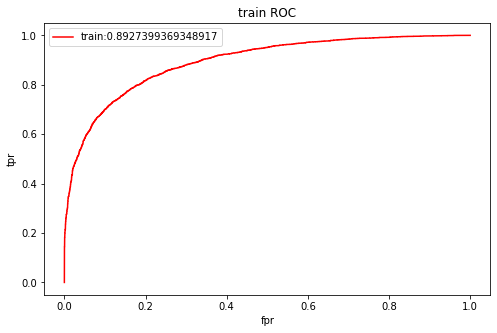

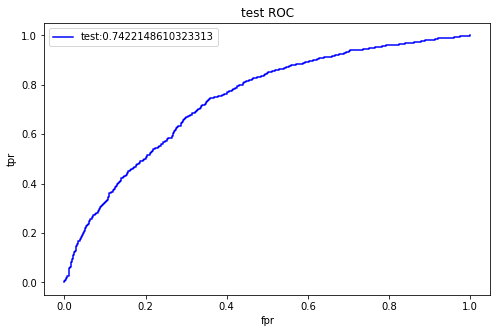

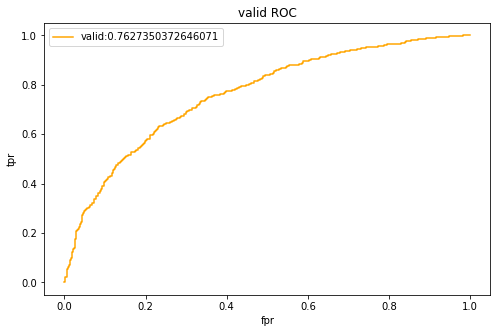

In [28]:
def plot_roc(color,name='test'): # name can be test train or validation
        plt.figure(figsize=(8,5))
        plt.plot(model.fpr[name],model.tpr[name],label=f"{name}:{model.auc_[name]}",color=color)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.legend()
        plt.title(f'{name} ROC')
        plt.show()

plot_roc(name='train',color='red')
plot_roc(name='test',color='blue')
plot_roc(name='valid',color='orange')

In [33]:
message = {'pretrained':True,
          'classifier_1':'conv2d(512,2,ker=1,stri=1,pad=0)',
          'cuda':1,
          'train':acc_train,
          'test':acc_test,
          'valid':acc_valid}

In [34]:
try:
    torch.save({'model':squeeze_1_0.state_dict(),'message':message},'saved_models/squeeze_01.pth')
    print('saved')
except Exception as e:
    print(e)

saved


In [35]:
model.save_model('saved_models/squeeze_01_best_model.pth',message)

model saved


# Training and testing of models

In [32]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-5
optimizer = optim.Adam(params=squeeze_1_0.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
n_epochs=26
model1.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

one of the best validation acc found
epoch:[1/26],memory:[0.9354524612426758/10.91650390625], lr:[3e-05]
train_accuracy:0.69375, train_loss:0.588092393875122
val_acc:0.6974516386787096,val_loss:0.5827159049610297

epoch:[2/26],memory:[0.9436993598937988/10.91650390625], lr:[3e-05]
train_accuracy:0.693375, train_loss:0.5895752806663513
val_acc:0.6949404776096344,val_loss:0.5805057920515537

epoch:[3/26],memory:[0.9436993598937988/10.91650390625], lr:[3e-05]
train_accuracy:0.6935, train_loss:0.5885280423164367
val_acc:0.6957775304714838,val_loss:0.5816007840136687

epoch:[4/26],memory:[0.9436993598937988/10.91650390625], lr:[3e-05]
train_accuracy:0.692875, train_loss:0.5911723148822784
val_acc:0.6974516386787096,val_loss:0.5836148336529732

epoch:[5/26],memory:[0.9436993598937988/10.91650390625], lr:[3e-05]
train_accuracy:0.6965, train_loss:0.5880791461467743
val_acc:0.6966145858168602,val_loss:0.5785189867019653

epoch:[6/26],memory:[0.9436993598937988/10.91650390625], lr:[3e-05]
train_